In [140]:
import pandas as pd
credit = pd.read_csv('default of credit card clients.csv', header =1)


In [141]:
credit.describe()
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

In [142]:
credit.shape


(30000, 25)

In [143]:
df=credit
df.EDUCATION.value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [144]:
## remap 4,5,6 as 4
df['EDUCATION'] = df.apply(lambda x: 4 if x['EDUCATION'] >= 4 else x['EDUCATION'],axis=1)
## 0 is considered invalid
df = df[df.EDUCATION != 0]

In [145]:
df.shape

(29986, 25)

In [146]:
df.EDUCATION.value_counts()

2    14030
1    10585
3     4917
4      454
Name: EDUCATION, dtype: int64

In [147]:
## Marriage field needs cleaning too
df.MARRIAGE.value_counts()

2    15954
1    13655
3      323
0       54
Name: MARRIAGE, dtype: int64

In [148]:
df = df[df.MARRIAGE != 0]

In [149]:
df.MARRIAGE.value_counts()

2    15954
1    13655
3      323
Name: MARRIAGE, dtype: int64

In [150]:
df.shape


(29932, 25)

In [151]:
df.rename(columns={'PAY_0':'PAY_1'}, inplace=True)
df.rename(columns={'default payment next month':'default_payment_next_month'}, inplace=True)
df = df.drop('ID' , axis='columns')

In [152]:
df.dtypes


LIMIT_BAL                     int64
SEX                           int64
EDUCATION                     int64
MARRIAGE                      int64
AGE                           int64
PAY_1                         int64
PAY_2                         int64
PAY_3                         int64
PAY_4                         int64
PAY_5                         int64
PAY_6                         int64
BILL_AMT1                     int64
BILL_AMT2                     int64
BILL_AMT3                     int64
BILL_AMT4                     int64
BILL_AMT5                     int64
BILL_AMT6                     int64
PAY_AMT1                      int64
PAY_AMT2                      int64
PAY_AMT3                      int64
PAY_AMT4                      int64
PAY_AMT5                      int64
PAY_AMT6                      int64
default_payment_next_month    int64
dtype: object

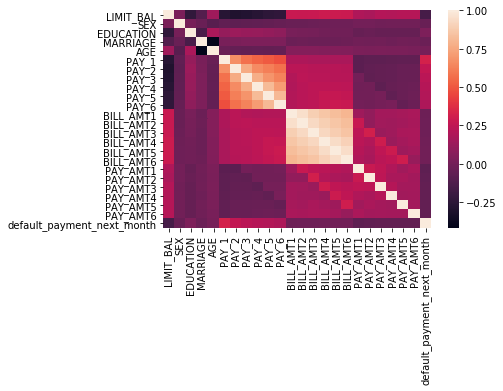

In [153]:
## Covriance and Visualization
import seaborn as sns
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

pd.scatter_matrix(df, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

In [154]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
LIMIT_BAL,1,0.025,-0.23,-0.11,0.14,-0.27,-0.3,-0.29,-0.27,-0.25,-0.24,0.29,0.28,0.28,0.29,0.3,0.29,0.2,0.18,0.21,0.2,0.22,0.22,-0.15
SEX,0.025,1,0.014,-0.03,-0.091,-0.058,-0.071,-0.066,-0.061,-0.055,-0.044,-0.034,-0.031,-0.025,-0.022,-0.017,-0.017,-0.00017,-0.0013,-0.0084,-0.0022,-0.0017,-0.0026,-0.04
EDUCATION,-0.23,0.014,1,-0.14,0.18,0.11,0.13,0.12,0.12,0.11,0.091,0.018,0.013,0.0082,-0.0047,-0.011,-0.011,-0.042,-0.033,-0.044,-0.041,-0.045,-0.044,0.035
MARRIAGE,-0.11,-0.03,-0.14,1,-0.42,0.019,0.024,0.033,0.033,0.035,0.034,-0.026,-0.024,-0.027,-0.025,-0.028,-0.023,-0.0054,-0.009,-0.0039,-0.013,-0.0021,-0.0076,-0.026
AGE,0.14,-0.091,0.18,-0.42,1,-0.039,-0.05,-0.053,-0.049,-0.054,-0.049,0.057,0.055,0.054,0.052,0.05,0.048,0.027,0.022,0.029,0.022,0.023,0.02,0.014
PAY_1,-0.27,-0.058,0.11,0.019,-0.039,1,0.67,0.57,0.54,0.51,0.47,0.19,0.19,0.18,0.18,0.18,0.18,-0.079,-0.07,-0.07,-0.064,-0.058,-0.059,0.33
PAY_2,-0.3,-0.071,0.13,0.024,-0.05,0.67,1,0.77,0.66,0.62,0.58,0.23,0.24,0.22,0.22,0.22,0.22,-0.081,-0.059,-0.056,-0.047,-0.037,-0.037,0.26
PAY_3,-0.29,-0.066,0.12,0.033,-0.053,0.57,0.77,1,0.78,0.69,0.63,0.21,0.24,0.23,0.23,0.23,0.22,0.0016,-0.067,-0.053,-0.046,-0.036,-0.036,0.24
PAY_4,-0.27,-0.061,0.12,0.033,-0.049,0.54,0.66,0.78,1,0.82,0.72,0.2,0.23,0.24,0.25,0.24,0.24,-0.0092,-0.0019,-0.069,-0.044,-0.034,-0.027,0.22
PAY_5,-0.25,-0.055,0.11,0.035,-0.054,0.51,0.62,0.69,0.82,1,0.82,0.21,0.23,0.24,0.27,0.27,0.26,-0.0059,-0.0031,0.0092,-0.058,-0.034,-0.023,0.2


In [155]:
### EDA is part of task 2-- please refer there

In [156]:
## Data split
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split

RANDOM_STATE = 2019

train_df, val_df = train_test_split(df, test_size=VALID_SIZE, 
                                    random_state=RANDOM_STATE, shuffle=True )

In [157]:
train_df.shape

(23945, 24)

In [158]:
val_df.shape

(5987, 24)

In [159]:
count_class_0, count_class_1 = train_df.default_payment_next_month.value_counts()
df_train = train_df
# Divide by class
df_class_0 = df_train[df_train['default_payment_next_month'] == 0]
df_class_1 = df_train[df_train['default_payment_next_month'] == 1]

df_class_0.shape
##(18649, 24)
df_class_1.shape

(5296, 24)

Random under-sampling:
1    5296
0    5296
Name: default_payment_next_month, dtype: int64


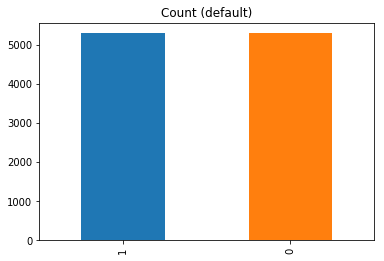

In [160]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.default_payment_next_month.value_counts())

df_test_under.default_payment_next_month.value_counts().plot(kind='bar', title='Count (default)');

In [161]:
## Lets set the training back
train_df = df_test_under
train_df.shape

(10592, 24)

In [162]:
## split features from output -- default_payment_next_month
output = 'default_payment_next_month'

cols = [ f for f in train_df.columns if train_df.dtypes[ f ] != "object"]
cols
cols.remove(output)
features = cols
features

['LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

In [163]:
def process_categorical_features(df):
    dummies_education = pd.get_dummies(df.EDUCATION, prefix="EDUCATION", drop_first=True)
    dummies_marriage = pd.get_dummies(df.MARRIAGE, prefix="MARRIAGE", drop_first=True)
    dummies_pay_1 = pd.get_dummies(df.MARRIAGE, prefix="PAY_1", drop_first=True)
    dummies_pay_2 = pd.get_dummies(df.MARRIAGE, prefix="PAY_2", drop_first=True)
    dummies_pay_3 = pd.get_dummies(df.MARRIAGE, prefix="PAY_3", drop_first=True)
    dummies_pay_4 = pd.get_dummies(df.MARRIAGE, prefix="PAY_4", drop_first=True)
    dummies_pay_5 = pd.get_dummies(df.MARRIAGE, prefix="PAY_5", drop_first=True)
    dummies_pay_6 = pd.get_dummies(df.MARRIAGE, prefix="PAY_6", drop_first=True)
    df.drop(["EDUCATION", "MARRIAGE", "PAY_1", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"], axis=1, inplace=True)
    return pd.concat([df, dummies_education, dummies_marriage, dummies_pay_1,
                     dummies_pay_2, dummies_pay_3, dummies_pay_4, dummies_pay_5, dummies_pay_6], axis=1)
df = process_categorical_features(train_df)

In [164]:
df.dtypes

LIMIT_BAL                     int64
SEX                           int64
AGE                           int64
BILL_AMT1                     int64
BILL_AMT2                     int64
BILL_AMT3                     int64
BILL_AMT4                     int64
BILL_AMT5                     int64
BILL_AMT6                     int64
PAY_AMT1                      int64
PAY_AMT2                      int64
PAY_AMT3                      int64
PAY_AMT4                      int64
PAY_AMT5                      int64
PAY_AMT6                      int64
default_payment_next_month    int64
EDUCATION_2                   uint8
EDUCATION_3                   uint8
EDUCATION_4                   uint8
MARRIAGE_2                    uint8
MARRIAGE_3                    uint8
PAY_1_2                       uint8
PAY_1_3                       uint8
PAY_2_2                       uint8
PAY_2_3                       uint8
PAY_3_2                       uint8
PAY_3_3                       uint8
PAY_4_2                     

In [165]:
## split features from output -- default_payment_next_month
df
output = 'default_payment_next_month'

cols = [ f for f in df.columns if df.dtypes[ f ] != "object"]
cols
cols.remove(output)
features = cols
features

['LIMIT_BAL',
 'SEX',
 'AGE',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'EDUCATION_2',
 'EDUCATION_3',
 'EDUCATION_4',
 'MARRIAGE_2',
 'MARRIAGE_3',
 'PAY_1_2',
 'PAY_1_3',
 'PAY_2_2',
 'PAY_2_3',
 'PAY_3_2',
 'PAY_3_3',
 'PAY_4_2',
 'PAY_4_3',
 'PAY_5_2',
 'PAY_5_3',
 'PAY_6_2',
 'PAY_6_3']

In [166]:
df.dtypes

LIMIT_BAL                     int64
SEX                           int64
AGE                           int64
BILL_AMT1                     int64
BILL_AMT2                     int64
BILL_AMT3                     int64
BILL_AMT4                     int64
BILL_AMT5                     int64
BILL_AMT6                     int64
PAY_AMT1                      int64
PAY_AMT2                      int64
PAY_AMT3                      int64
PAY_AMT4                      int64
PAY_AMT5                      int64
PAY_AMT6                      int64
default_payment_next_month    int64
EDUCATION_2                   uint8
EDUCATION_3                   uint8
EDUCATION_4                   uint8
MARRIAGE_2                    uint8
MARRIAGE_3                    uint8
PAY_1_2                       uint8
PAY_1_3                       uint8
PAY_2_2                       uint8
PAY_2_3                       uint8
PAY_3_2                       uint8
PAY_3_3                       uint8
PAY_4_2                     

/Users/svrrao/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/svrrao/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/svrrao/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


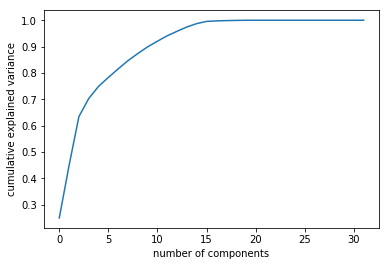

In [167]:
data = df
X = data[features].values    
y = data[ output ].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2)

from sklearn.preprocessing import StandardScaler
scX = StandardScaler()
X_train = scX.fit_transform( X_train )
X_test = scX.transform( X_test )

from sklearn.decomposition import PCA

pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

# We'll need some metrics to evaluate our models
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

In [168]:
## data is not linearly separable - using RandomForest classifier and kernel-SVM



#-------------- 
# Random Forest 
#--------------
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=10)
classifier.fit( X_train, y_train )
y_pred = classifier.predict( X_test )

cm = confusion_matrix( y_test, y_pred )
print("Accuracy on Test Set for RandomForest = %.2f" % ((cm[0,0] + cm[1,1] )/len(X_test)))
scoresRF = cross_val_score( classifier, X_train, y_train, cv=10)
print("Mean RandomForest CrossVal Accuracy on Train Set %.2f, with std=%.2f" % (scoresRF.mean(), scoresRF.std() ))


Accuracy on Test Set for RandomForest = 0.63
Mean RandomForest CrossVal Accuracy on Train Set 0.63, with std=0.02


In [169]:
#-------------- 
# kernel SVM 
#--------------
from sklearn.svm import SVC
classifier1 = SVC(kernel="rbf")
classifier1.fit( X_train, y_train )
y_pred = classifier1.predict( X_test )

cm = confusion_matrix( y_test, y_pred )
print("Accuracy on Test Set for kernel-SVM = %.2f" % ((cm[0,0] + cm[1,1] )/len(X_test)))
scoresSVC = cross_val_score( classifier1, X_train, y_train, cv=10)
print("Mean kernel-SVM CrossVal Accuracy on Train Set %.2f, with std=%.2f" % (scoresSVC.mean(), scoresSVC.std() ))

Accuracy on Test Set for kernel-SVM = 0.62


/Users/svrrao/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/svrrao/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/svrrao/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/svrrao/anaconda3/lib/python3.7/site-packages/

Mean kernel-SVM CrossVal Accuracy on Train Set 0.62, with std=0.01


In [170]:
#-------------- 
# K-NEIGHBOURS 
#--------------
from sklearn.neighbors import KNeighborsClassifier
classifier3 = KNeighborsClassifier(n_neighbors=5)
classifier3.fit( X_train, y_train )
y_pred = classifier3.predict( X_test )
cm = confusion_matrix( y_test, y_pred )
print("Accuracy on Test Set for KNeighborsClassifier = %.2f" % ((cm[0,0] + cm[1,1] )/len(X_test)))
scoresKN = cross_val_score( classifier3, X_train, y_train, cv=10)
print("Mean KN CrossVal Accuracy on Train Set Set %.2f, with std=%.2f" % (scoresKN.mean(), scoresKN.std() ))


Accuracy on Test Set for KNeighborsClassifier = 0.58
Mean KN CrossVal Accuracy on Train Set Set 0.58, with std=0.01


In [171]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb

classifier4 = xgb.sklearn.XGBClassifier(seed=42, nthread=-1)
classifier4.fit(X_train, y_train)
##XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
##       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
##       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
##       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
##       scale_pos_weight=1, seed=42, silent=True, subsample=1)
y_pred = classifier4.predict( X_test )
cm = confusion_matrix( y_test, y_pred )
scoresXG = cross_val_score( classifier4, X_train, y_train, cv=10)
print("Mean XGB CrossVal Accuracy on Train Set Set %.2f, with std=%.2f" % (scoresXG.mean(), scoresXG.std() ))
print("Model Accuray: {:.2f}%".format(100*classifier4.score(X_test, y_test)))


Mean XGB CrossVal Accuracy on Train Set Set 0.68, with std=0.02
Model Accuray: 67.48%


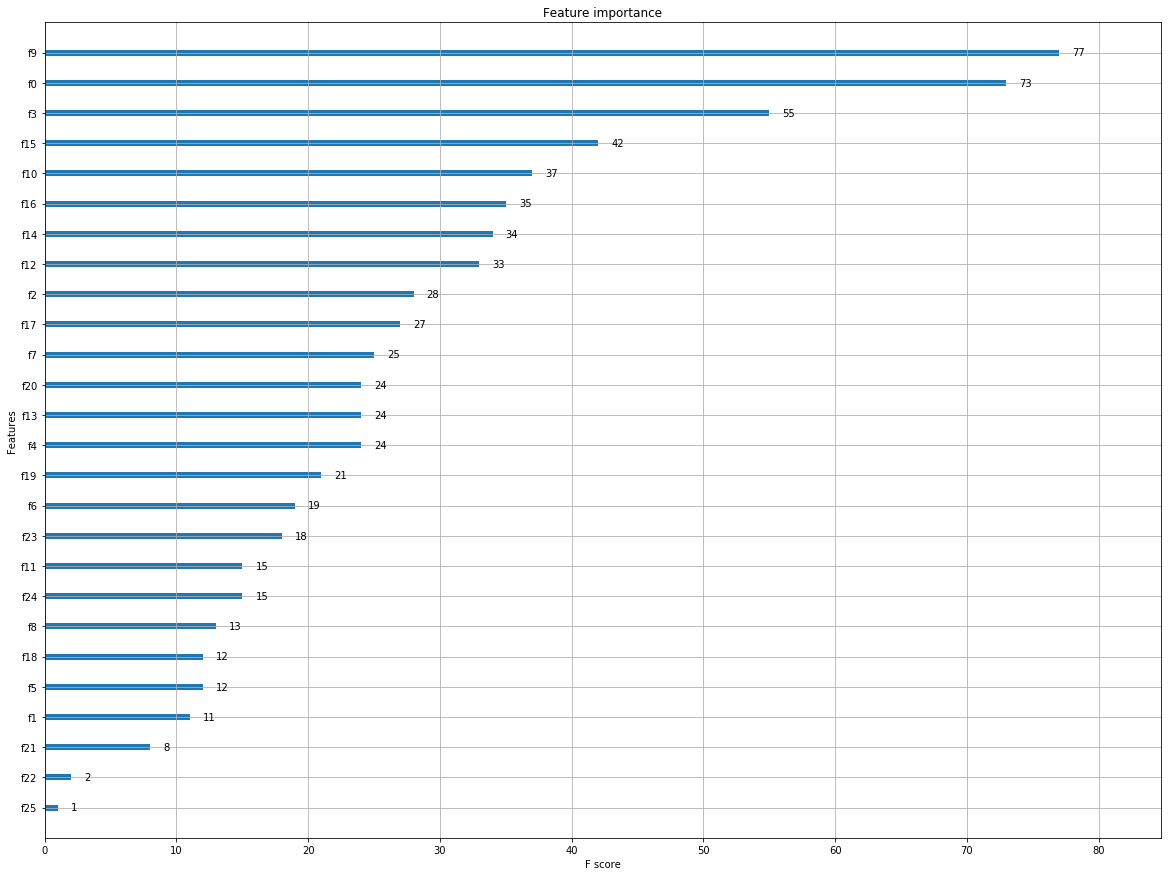

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
xgb.plot_importance(classifier4, ax=plt.gca())
